In [55]:
import torchvision
import torch
import matplotlib.pyplot as plt
import imageio
import os
import tensorflow as tf
import random
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import glob
import math
import timm
import numpy as np
import matplotlib.image as image
import pandas as pd

from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import Dataset, DataLoader
from PIL import ImageFilter
from PIL import Image
from einops import rearrange
from timm.loss import LabelSmoothingCrossEntropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [56]:
csv_path = "NPTU-DL-Final-Project/train.csv"
train_path = "NPTU-DL-Final-Project/train"
test_path = "NPTU-DL-Final-Project/test"

df = pd.read_csv(csv_path)

# 顯示前幾行
print(df.head())
print(f"data shape {df.shape}")
print(os.listdir(train_path))  # 列出 train 目錄中的文件

                               img_file            label
0  78fbc980fba54a0e98da22352d44e51d.jpg          croquet
1  6c761e579cc542ebbaa9a932c9b22b08.jpg          fencing
2  f475146a31564c929e09f0724af3723b.jpg  sailboat racing
3  bfa1d3e9b6684d43ab81eb836670d942.jpg       gymnastics
4  c42ce1c6a0944b0c86a48950f87bc2fe.jpg     roller derby
data shape (15198, 2)
['396fc76513b5440c9e05870ad2004a7b.jpg', '344f10db75654be48c81a07216248ae6.jpg', 'd610137946bb4d26b9478dc9128576ad.jpg', '34e47abfb91b4edbb761cb0b0bb270c2.jpg', 'edfddbc638d34ee3a9b5c7f7b92dd10c.jpg', '7f26efab6ee94a778d42e4f4e59de638.jpg', '9eefcffc51694a2096fcb3460769f474.jpg', 'ec7d4eeec3f84b8d9044cf08cbec8ec7.jpg', '202c2da6a2194103844f7a47b76be18b.jpg', 'd71a36624d8d4136a6f1c01315798441.jpg', '27030e158e5f43af8f6b602fd7939907.jpg', 'c3f473794c3c4348927ea637b1b4ba52.jpg', '8f1d1a0866c048c39b8fb3702faa013f.jpg', 'a17e3c85533047048f9cf772009c9219.jpg', '7b1b995b2f27401382467772b396107a.jpg', '2ba1b918f4bc41ff8c11b46c2eb42de7.j

In [57]:
img_height, img_width = 224, 224

In [70]:
train_datagen = ImageDataGenerator(rescale=0.1, validation_split=0.2)  # 將像素值縮放到 [0, 1]
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='img_file',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='img_file',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print(len(train_generator.class_indices))

Found 12159 validated image filenames belonging to 109 classes.
Found 3039 validated image filenames belonging to 109 classes.
109


In [59]:
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((img_height, img_width))
    image_array = np.array(image) / 255.0  # 歸一化
    return image_array

In [60]:
# x_train = []
# y_train = []

# sports_list = os.listdir(train_path)
# print(f"There are total {len(sports_list)} img in this dataset!\n")

# label_to_image = {}
# for index, row in df.iterrows():
#     image_name = row['img_file']
#     image_path = os.path.join(train_path, image_name)
#     if os.path.exists(image_path):
#         image_array = load_and_preprocess_image(image_path)
#         x_train.append(image_array)
#         y_train.append(row['label'])

# print(f"Image : {x_train} Label : {y_train}")
# # images = np.array(images)
# # labels = np.array(labels)

In [61]:
# print(x_train)
# x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') 

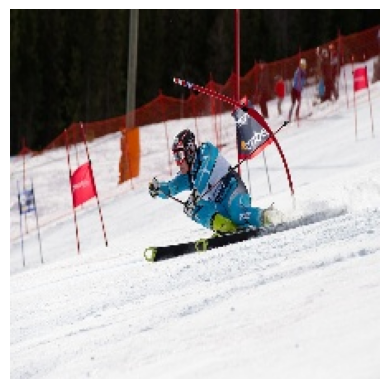

(224, 224, 3)

In [62]:
image1_path = "NPTU-DL-Final-Project/train/0a0e56930d944393a3a038c0e21c6734.jpg"
image1 = image.imread(image1_path)
plt.imshow(image1)
plt.axis(False)
plt.show()

image1.shape

In [64]:
num_classes = len(np.unique(df['label']))
print(f"Number of classes: {num_classes}")

Number of classes: 109


In [71]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])



In [72]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

In [77]:
test_datagen = ImageDataGenerator(rescale=0.1)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode=None,  # 因為測試集沒有標籤
    shuffle=False
)

# 預測
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 如果需要，可以將預測結果保存到 CSV 文件中
filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames, "Predictions": predicted_classes})
results.to_csv("results.csv", index=False)

Found 0 images belonging to 0 classes.


ValueError: Asked to retrieve element 0, but the Sequence has length 0